In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import time
import os
from tqdm import tqdm

2025-05-01 23:45:45.588250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746143145.832445      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746143145.905999      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
IMAGE_SIZE = (150, 150)

# Paths to dataset
DATA_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train"
VAL_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test"

# Preprocessing
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)

# Create dataloaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [4]:
# residual block for ResNet
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        f = self.relu(self.bn1(self.conv1(x)))
        f = self.relu(self.bn2(self.conv2(f)))
        f = self.bn3(self.conv3(f))

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        f += identity
        f = self.relu(f)
        return f

In [5]:
# ResNet architecture 
class Resnet(nn.Module):
    def __init__(self, block, img_channels, num_classes):
        super(Resnet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, 3, 1)
        self.layer2 = self._make_layer(block, 128, 4, 2)
        self.layer3 = self._make_layer(block, 256, 6, 2)
        self.layer4 = self._make_layer(block, 512, 3, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x

    def _make_layer(self, block, out_channels, number_residual_block, stride):
        layers = []
        identity_downsample = None

        if stride != 1 or self.in_channels != 4 * out_channels:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, 4 * out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(4 * out_channels)
            )

        layers.append(block(self.in_channels, out_channels, identity_downsample=identity_downsample, stride=stride))
        self.in_channels = out_channels * 4

        for i in range(1, number_residual_block):
            layers.append(block(self.in_channels, out_channels))
            
        return nn.Sequential(*layers)

In [6]:
def Resnet50(img_channels=3, num_classes=6):
    return Resnet(block, img_channels, num_classes)

In [7]:
# Initialize TensorBoard writers
current_time = time.strftime("%Y%m%d-%H%M%S")
adam_writer = SummaryWriter(f'runs/ResNet50_Adam_{current_time}')
sgd_writer = SummaryWriter(f'runs/ResNet50_SGD_{current_time}')

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Define two variants with different hyperparameters
variants = [
    {
        'name': 'ResNet50_Adam',
        'optimizer': 'adam',
        'lr': 0.001,
        'weight_decay': 0.0001,
        'scheduler': True,
        'writer': adam_writer
    },
    {
        'name': 'ResNet50_SGD',
        'optimizer': 'sgd',
        'lr': 0.01,
        'momentum': 0.9,
        'weight_decay': 0.001,
        'scheduler': True,
        'writer': sgd_writer
    }
]

In [9]:
# Training and evaluation functions
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, device, num_epochs, variant):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_acc = 0.0
    best_model_wts = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"{variant['name']} - Epoch {epoch+1}/{num_epochs} [Training]")
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
            
            # Log batch metrics to TensorBoard
            variant['writer'].add_scalar('Batch/Train_Loss', loss.item(), epoch * len(train_loader) + batch_idx)
            variant['writer'].add_scalar('Batch/Train_Accuracy', 100. * correct / total, epoch * len(train_loader) + batch_idx)
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        val_loss, val_acc, all_preds, all_targets = evaluate_model(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Log epoch metrics to TensorBoard
        variant['writer'].add_scalar('Epoch/Train_Loss', train_loss, epoch)
        variant['writer'].add_scalar('Epoch/Train_Accuracy', train_acc, epoch)
        variant['writer'].add_scalar('Epoch/Val_Loss', val_loss, epoch)
        variant['writer'].add_scalar('Epoch/Val_Accuracy', val_acc, epoch)
        
        # Step the scheduler
        if scheduler is not None:
            scheduler.step(val_acc)
        
        print(f"{variant['name']} - Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, f"best_{variant['name']}.pth")
            print(f"New best model saved with val accuracy: {best_acc:.2f}%")
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [10]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Evaluating")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            progress_bar.set_postfix({
                'loss': running_loss / (len(all_preds) / targets.size(0)),
                'acc': 100. * correct / total
            })
    
    val_loss = running_loss / len(loader)
    val_acc = 100. * correct / total
    
    return val_loss, val_acc, all_preds, all_targets

In [11]:
def plot_confusion_matrix(all_targets, all_preds, class_names, model_name):
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

# Dictionary to store results
results = {}


Training ResNet50_Adam...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.43it/s, loss=0.796, acc=65.4]


ResNet50_Adam - Epoch 1/30: Train Loss: 1.0184, Train Acc: 61.64% | Val Loss: 0.9079, Val Acc: 65.40%
New best model saved with val accuracy: 65.40%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.08it/s, loss=0.497, acc=79.5]


ResNet50_Adam - Epoch 2/30: Train Loss: 0.6205, Train Acc: 77.23% | Val Loss: 0.5659, Val Acc: 79.50%
New best model saved with val accuracy: 79.50%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.97it/s, loss=0.561, acc=80.3]


ResNet50_Adam - Epoch 3/30: Train Loss: 0.5321, Train Acc: 80.66% | Val Loss: 0.6400, Val Acc: 80.30%
New best model saved with val accuracy: 80.30%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, loss=1, acc=65.5]    


ResNet50_Adam - Epoch 4/30: Train Loss: 0.5471, Train Acc: 80.44% | Val Loss: 1.1438, Val Acc: 65.50%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.96it/s, loss=0.517, acc=80.2]


ResNet50_Adam - Epoch 5/30: Train Loss: 0.4746, Train Acc: 82.76% | Val Loss: 0.5893, Val Acc: 80.17%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.20it/s, loss=0.424, acc=83.4]


ResNet50_Adam - Epoch 6/30: Train Loss: 0.4333, Train Acc: 84.41% | Val Loss: 0.4830, Val Acc: 83.40%
New best model saved with val accuracy: 83.40%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.16it/s, loss=0.619, acc=74.6]


ResNet50_Adam - Epoch 7/30: Train Loss: 0.4150, Train Acc: 85.44% | Val Loss: 0.7061, Val Acc: 74.63%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.37it/s, loss=0.494, acc=79.7]


ResNet50_Adam - Epoch 8/30: Train Loss: 0.3997, Train Acc: 85.97% | Val Loss: 0.5629, Val Acc: 79.67%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, loss=0.421, acc=83.7]


ResNet50_Adam - Epoch 9/30: Train Loss: 0.4281, Train Acc: 84.69% | Val Loss: 0.4802, Val Acc: 83.67%
New best model saved with val accuracy: 83.67%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.23it/s, loss=0.459, acc=82.3]


ResNet50_Adam - Epoch 10/30: Train Loss: 0.3862, Train Acc: 86.39% | Val Loss: 0.5231, Val Acc: 82.33%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.32it/s, loss=0.38, acc=85.1] 


ResNet50_Adam - Epoch 11/30: Train Loss: 0.3731, Train Acc: 86.85% | Val Loss: 0.4333, Val Acc: 85.13%
New best model saved with val accuracy: 85.13%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.43it/s, loss=0.379, acc=84.1]


ResNet50_Adam - Epoch 12/30: Train Loss: 0.3669, Train Acc: 86.97% | Val Loss: 0.4322, Val Acc: 84.07%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.39it/s, loss=0.418, acc=83.8]


ResNet50_Adam - Epoch 13/30: Train Loss: 0.3434, Train Acc: 87.91% | Val Loss: 0.4770, Val Acc: 83.77%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.61it/s, loss=0.36, acc=85.7] 


ResNet50_Adam - Epoch 14/30: Train Loss: 0.3458, Train Acc: 87.64% | Val Loss: 0.4104, Val Acc: 85.73%
New best model saved with val accuracy: 85.73%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.96it/s, loss=0.361, acc=85.1]


ResNet50_Adam - Epoch 15/30: Train Loss: 0.3313, Train Acc: 88.22% | Val Loss: 0.4110, Val Acc: 85.07%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.00it/s, loss=0.355, acc=85.4]


ResNet50_Adam - Epoch 16/30: Train Loss: 0.3280, Train Acc: 88.29% | Val Loss: 0.4048, Val Acc: 85.40%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.98it/s, loss=0.512, acc=82.9]


ResNet50_Adam - Epoch 17/30: Train Loss: 0.3213, Train Acc: 88.73% | Val Loss: 0.5832, Val Acc: 82.90%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.15it/s, loss=0.324, acc=86.8]


ResNet50_Adam - Epoch 18/30: Train Loss: 0.3158, Train Acc: 88.81% | Val Loss: 0.3698, Val Acc: 86.77%
New best model saved with val accuracy: 86.77%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.12it/s, loss=0.424, acc=82.5]


ResNet50_Adam - Epoch 19/30: Train Loss: 0.2999, Train Acc: 89.19% | Val Loss: 0.4829, Val Acc: 82.50%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.15it/s, loss=0.354, acc=85.4]


ResNet50_Adam - Epoch 20/30: Train Loss: 0.2940, Train Acc: 89.55% | Val Loss: 0.4035, Val Acc: 85.37%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.09it/s, loss=0.34, acc=86.2] 


ResNet50_Adam - Epoch 21/30: Train Loss: 0.2918, Train Acc: 89.33% | Val Loss: 0.3871, Val Acc: 86.23%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.16it/s, loss=0.337, acc=86.2]


ResNet50_Adam - Epoch 22/30: Train Loss: 0.2845, Train Acc: 89.59% | Val Loss: 0.3840, Val Acc: 86.23%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.09it/s, loss=0.284, acc=89]  


ResNet50_Adam - Epoch 23/30: Train Loss: 0.2099, Train Acc: 92.70% | Val Loss: 0.3240, Val Acc: 89.00%
New best model saved with val accuracy: 89.00%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.17it/s, loss=0.306, acc=88.5]


ResNet50_Adam - Epoch 24/30: Train Loss: 0.1931, Train Acc: 93.31% | Val Loss: 0.3493, Val Acc: 88.53%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.15it/s, loss=0.303, acc=88.4]


ResNet50_Adam - Epoch 25/30: Train Loss: 0.1934, Train Acc: 93.15% | Val Loss: 0.3450, Val Acc: 88.40%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.11it/s, loss=0.278, acc=88.8]


ResNet50_Adam - Epoch 26/30: Train Loss: 0.1850, Train Acc: 93.27% | Val Loss: 0.3168, Val Acc: 88.77%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.13it/s, loss=0.299, acc=88.3]


ResNet50_Adam - Epoch 27/30: Train Loss: 0.1830, Train Acc: 93.54% | Val Loss: 0.3404, Val Acc: 88.30%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.11it/s, loss=0.29, acc=88.7] 


ResNet50_Adam - Epoch 28/30: Train Loss: 0.1295, Train Acc: 95.53% | Val Loss: 0.3309, Val Acc: 88.70%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.17it/s, loss=0.301, acc=89.1]


ResNet50_Adam - Epoch 29/30: Train Loss: 0.1053, Train Acc: 96.44% | Val Loss: 0.3433, Val Acc: 89.07%
New best model saved with val accuracy: 89.07%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.07it/s, loss=0.293, acc=89.7]


ResNet50_Adam - Epoch 30/30: Train Loss: 0.0912, Train Acc: 96.89% | Val Loss: 0.3337, Val Acc: 89.67%
New best model saved with val accuracy: 89.67%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  8.10it/s, loss=0.292, acc=89.6]



Classification Report for ResNet50_Adam:
              precision    recall  f1-score      support
buildings      0.921569  0.860412  0.889941   437.000000
forest         0.972917  0.985232  0.979036   474.000000
glacier        0.851986  0.853526  0.852755   553.000000
mountain       0.831193  0.862857  0.846729   525.000000
sea            0.915187  0.909804  0.912488   510.000000
street         0.903162  0.912176  0.907646   501.000000
accuracy       0.896333  0.896333  0.896333     0.896333
macro avg      0.899335  0.897334  0.898099  3000.000000
weighted avg   0.896881  0.896333  0.896391  3000.000000


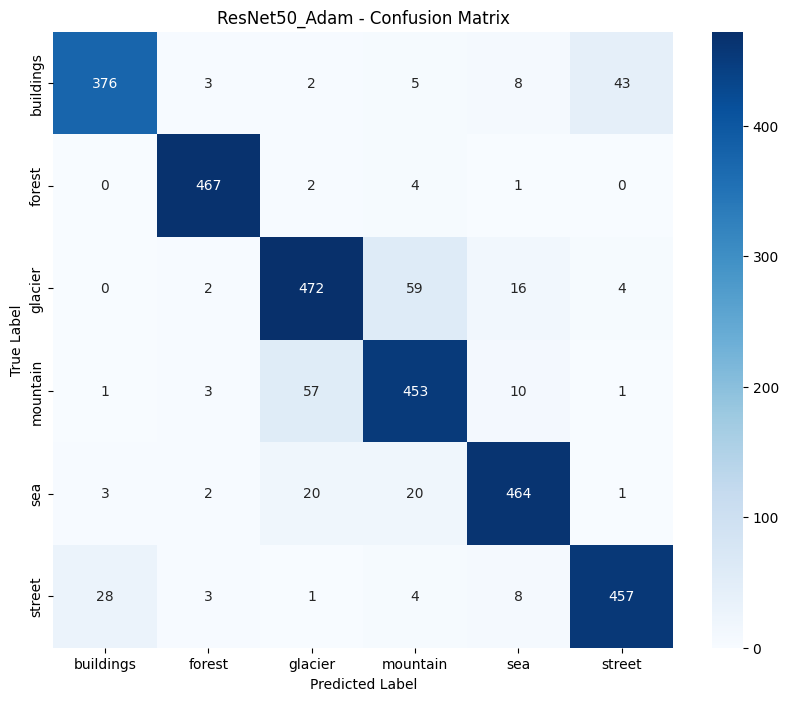


Training ResNet50_SGD...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.83it/s, loss=0.983, acc=59]  


ResNet50_SGD - Epoch 1/30: Train Loss: 1.6424, Train Acc: 44.58% | Val Loss: 1.1208, Val Acc: 59.00%
New best model saved with val accuracy: 59.00%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, loss=0.882, acc=72.8]


ResNet50_SGD - Epoch 2/30: Train Loss: 0.8496, Train Acc: 67.80% | Val Loss: 1.0049, Val Acc: 72.77%
New best model saved with val accuracy: 72.77%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.92it/s, loss=0.574, acc=78.3]


ResNet50_SGD - Epoch 3/30: Train Loss: 0.6617, Train Acc: 76.02% | Val Loss: 0.6544, Val Acc: 78.33%
New best model saved with val accuracy: 78.33%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, loss=0.509, acc=79.2]


ResNet50_SGD - Epoch 4/30: Train Loss: 0.5702, Train Acc: 79.49% | Val Loss: 0.5800, Val Acc: 79.17%
New best model saved with val accuracy: 79.17%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, loss=0.783, acc=67.8]


ResNet50_SGD - Epoch 5/30: Train Loss: 0.5065, Train Acc: 81.85% | Val Loss: 0.8928, Val Acc: 67.83%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, loss=0.43, acc=82.4] 


ResNet50_SGD - Epoch 6/30: Train Loss: 0.4790, Train Acc: 83.01% | Val Loss: 0.4899, Val Acc: 82.37%
New best model saved with val accuracy: 82.37%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.67it/s, loss=0.527, acc=78.5]


ResNet50_SGD - Epoch 7/30: Train Loss: 0.4352, Train Acc: 84.51% | Val Loss: 0.6007, Val Acc: 78.50%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.91it/s, loss=0.357, acc=85.3]


ResNet50_SGD - Epoch 8/30: Train Loss: 0.4242, Train Acc: 85.12% | Val Loss: 0.4066, Val Acc: 85.30%
New best model saved with val accuracy: 85.30%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, loss=0.378, acc=85]  


ResNet50_SGD - Epoch 9/30: Train Loss: 0.3820, Train Acc: 86.21% | Val Loss: 0.4306, Val Acc: 85.03%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, loss=0.424, acc=82.2]


ResNet50_SGD - Epoch 10/30: Train Loss: 0.3674, Train Acc: 86.79% | Val Loss: 0.4837, Val Acc: 82.20%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, loss=0.4, acc=83.7]  


ResNet50_SGD - Epoch 11/30: Train Loss: 0.3494, Train Acc: 87.58% | Val Loss: 0.4561, Val Acc: 83.70%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, loss=0.433, acc=84.2]


ResNet50_SGD - Epoch 12/30: Train Loss: 0.3306, Train Acc: 87.80% | Val Loss: 0.4934, Val Acc: 84.23%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, loss=0.343, acc=87]  


ResNet50_SGD - Epoch 13/30: Train Loss: 0.2433, Train Acc: 91.29% | Val Loss: 0.3911, Val Acc: 87.00%
New best model saved with val accuracy: 87.00%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, loss=0.371, acc=86.1]


ResNet50_SGD - Epoch 14/30: Train Loss: 0.2140, Train Acc: 92.43% | Val Loss: 0.4226, Val Acc: 86.10%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, loss=0.358, acc=86.7]


ResNet50_SGD - Epoch 15/30: Train Loss: 0.2055, Train Acc: 92.64% | Val Loss: 0.4085, Val Acc: 86.73%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, loss=0.405, acc=85.9]


ResNet50_SGD - Epoch 16/30: Train Loss: 0.1890, Train Acc: 93.31% | Val Loss: 0.4614, Val Acc: 85.93%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, loss=0.387, acc=85.7]


ResNet50_SGD - Epoch 17/30: Train Loss: 0.1774, Train Acc: 93.64% | Val Loss: 0.4415, Val Acc: 85.73%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, loss=0.412, acc=86.6]


ResNet50_SGD - Epoch 18/30: Train Loss: 0.1027, Train Acc: 96.43% | Val Loss: 0.4699, Val Acc: 86.60%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, loss=0.427, acc=86.4]


ResNet50_SGD - Epoch 19/30: Train Loss: 0.0819, Train Acc: 97.21% | Val Loss: 0.4868, Val Acc: 86.40%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, loss=0.471, acc=86.8]


ResNet50_SGD - Epoch 20/30: Train Loss: 0.0704, Train Acc: 97.56% | Val Loss: 0.5365, Val Acc: 86.77%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, loss=0.493, acc=87]  


ResNet50_SGD - Epoch 21/30: Train Loss: 0.0591, Train Acc: 97.93% | Val Loss: 0.5620, Val Acc: 86.97%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, loss=0.462, acc=87]  


ResNet50_SGD - Epoch 22/30: Train Loss: 0.0385, Train Acc: 98.75% | Val Loss: 0.5265, Val Acc: 87.03%
New best model saved with val accuracy: 87.03%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.60it/s, loss=0.512, acc=87.6]


ResNet50_SGD - Epoch 23/30: Train Loss: 0.0228, Train Acc: 99.31% | Val Loss: 0.5841, Val Acc: 87.60%
New best model saved with val accuracy: 87.60%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, loss=0.513, acc=87.4]


ResNet50_SGD - Epoch 24/30: Train Loss: 0.0231, Train Acc: 99.32% | Val Loss: 0.5853, Val Acc: 87.40%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, loss=0.524, acc=87.6]


ResNet50_SGD - Epoch 25/30: Train Loss: 0.0183, Train Acc: 99.57% | Val Loss: 0.5974, Val Acc: 87.60%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, loss=0.522, acc=87.5]


ResNet50_SGD - Epoch 26/30: Train Loss: 0.0154, Train Acc: 99.58% | Val Loss: 0.5945, Val Acc: 87.47%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, loss=0.513, acc=88.1]


ResNet50_SGD - Epoch 27/30: Train Loss: 0.0142, Train Acc: 99.69% | Val Loss: 0.5851, Val Acc: 88.07%
New best model saved with val accuracy: 88.07%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, loss=0.534, acc=87.9]


ResNet50_SGD - Epoch 28/30: Train Loss: 0.0123, Train Acc: 99.65% | Val Loss: 0.6082, Val Acc: 87.87%


Evaluating: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, loss=0.547, acc=87.5]


ResNet50_SGD - Epoch 29/30: Train Loss: 0.0122, Train Acc: 99.66% | Val Loss: 0.6234, Val Acc: 87.47%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, loss=0.533, acc=87.7]


ResNet50_SGD - Epoch 30/30: Train Loss: 0.0106, Train Acc: 99.79% | Val Loss: 0.6079, Val Acc: 87.67%


Evaluating: 100%|██████████| 47/47 [00:05<00:00,  7.90it/s, loss=0.529, acc=87.7]



Classification Report for ResNet50_SGD:
              precision    recall  f1-score   support
buildings      0.895238  0.860412  0.877480   437.000
forest         0.956879  0.983122  0.969823   474.000
glacier        0.820513  0.810127  0.815287   553.000
mountain       0.820416  0.826667  0.823529   525.000
sea            0.896282  0.898039  0.897160   510.000
street         0.885602  0.896208  0.890873   501.000
accuracy       0.877000  0.877000  0.877000     0.877
macro avg      0.879155  0.879096  0.879025  3000.000
weighted avg   0.876677  0.877000  0.876747  3000.000


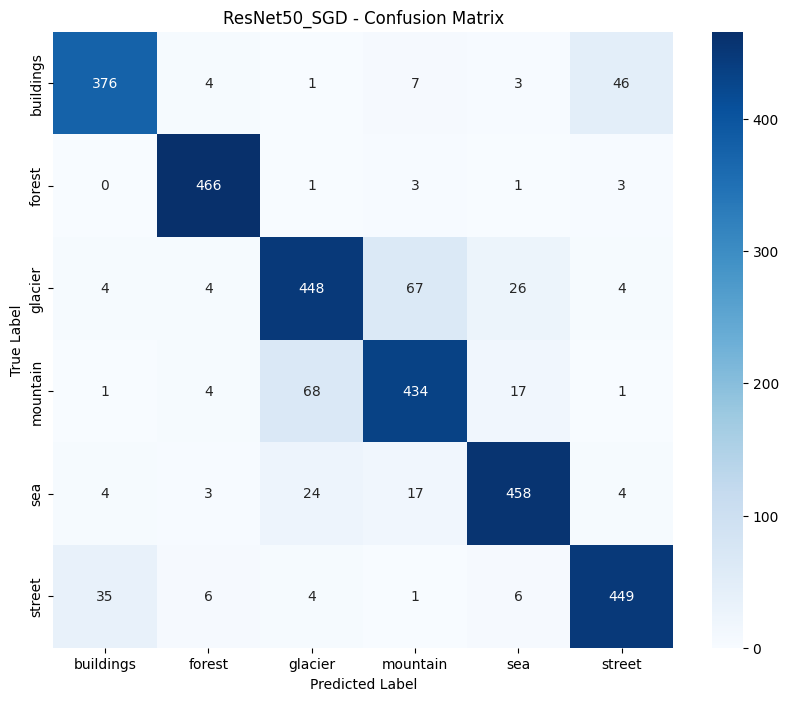

In [12]:
# Train and evaluate each variant
for variant in variants:
    print(f"\n{'='*50}")
    print(f"Training {variant['name']}...")
    print(f"{'='*50}")
    
    # Initialize model
    model = Resnet50(num_classes=len(train_dataset.classes)).to(device)
    
    # Define criterion
    criterion = nn.CrossEntropyLoss()
    
    # Define optimizer
    if variant['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=variant['lr'], weight_decay=variant['weight_decay'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=variant['lr'], momentum=variant.get('momentum', 0),
                             weight_decay=variant['weight_decay'])
    
    # Define scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5, verbose=True) if variant['scheduler'] else None
    
    # Train model
    num_epochs = 30
    trained_model, history = train_model(
        model, train_loader, val_loader, 
        optimizer, criterion, scheduler, 
        device, num_epochs, variant
    )
    
    # Final evaluation
    val_loss, val_acc, all_preds, all_targets = evaluate_model(trained_model, val_loader, criterion, device)
    
    # Generate classification report
    class_names = train_dataset.classes
    report = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f'{variant["name"]}_classification_report.csv')
    print(f"\nClassification Report for {variant['name']}:")
    print(report_df)
    
    # Plot confusion matrix
    plot_confusion_matrix(all_targets, all_preds, class_names, variant['name'])
    
    # Store results
    results[variant['name']] = {
        'val_accuracy': val_acc,
        'val_loss': val_loss,
        'history': history,
        'classification_report': report
    }
    
    # Close TensorBoard writer
    variant['writer'].close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs